In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import warnings
warnings.simplefilter("ignore") 
import logging
logging.basicConfig(level=logging.ERROR)

In [94]:
from kinoml.datasets.chembl import ChEMBLDatasetProvider
chembl = ChEMBLDatasetProvider.from_source()

In [62]:
chembl

<ChEMBLDatasetProvider with 203380 pIC50Measurement measurements and 162584 systems>

In [63]:
df = chembl.to_dataframe()
df

,Systems,n_components,Measurement,MeasurementType
0,P00533 & Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F...,2,7.387216,pIC50Measurement
1,P35968 & Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F...,2,4.782516,pIC50Measurement
2,P00533 & Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)...,2,6.769551,pIC50Measurement
3,P06239 & Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C...,2,6.853872,pIC50Measurement
4,P06239 & Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C...,2,5.928118,pIC50Measurement
...,...,...,...,...
203375,P42345 & CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)...,2,8.522879,pKdMeasurement
203376,P42345 & CO[C@H]1CC[C@H](N2C(=O)CNc3ncc(-c4ccc...,2,7.552842,pKdMeasurement
203377,P42345 & CNC(=O)c1cccc(-c2ccc3c(N4CCOC[C@@H]4C...,2,9.853872,pKdMeasurement
203378,P42345 & CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O...,2,9.221849,pKdMeasurement


Min values:  3.0
Max values:  14.096910013008056


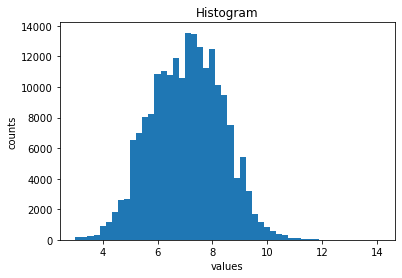

In [67]:
import pandas as pd
from matplotlib import pyplot as plt
def hist_plot(values):
    '''
    Plots the histogram of given values.
    '''
    print('Min values: ' , pd.np.min(values))
    print('Max values: ' , pd.np.max(values))
    f = plt.figure()
    plt.title("Histogram")
    plt.xlabel("values")
    plt.ylabel("counts")
    plt.hist(values, bins=50)
    plt.show()

hist_plot(df.Measurement)

In [68]:
print("Measurements:", len(chembl.measurements))
print("Systems:", len(chembl.systems))
print("Proteins:", len(set([s.protein for s in chembl.systems])))
print("Ligands:",len(set([s.ligand.name for s in chembl.systems])))

Measurements: 203380
Systems: 162584
Proteins: 422
Ligands: 103097


Having this many ligands (compared to PKIS2) makes this dataset take much more memory and longer (~10 mins) to initialize!

In [78]:
from kinoml.features.ligand import SmilesToLigandFeaturizer, MorganFingerprintFeaturizer
from kinoml.features.protein import AminoAcidCompositionFeaturizer
from kinoml.features.core import ScaleFeaturizer, Concatenated, Pipeline

morgan_featurizer = Pipeline([SmilesToLigandFeaturizer(), MorganFingerprintFeaturizer(nbits=1024, radius=2)])
composition_featurizer = Pipeline([AminoAcidCompositionFeaturizer(), ScaleFeaturizer()])
concat_featurizers = Concatenated([morgan_featurizer, composition_featurizer], axis=0)

You can prefeaturize everything before the loop, or delay the featurization until the systems are needed by passing the featurizer to the `to_pytorch` constructor.

In [72]:
# # prefeaturize everything
# subchembl.featurize(concat_featurizers)
# # pass the featurizer to pytorch to featurize on the fly while optimizing
# datasets = subchembl.to_pytorch(featurizer=concat_featurizers)
# datasets

We are creating a small subset here with just pIC50 measurements:

In [71]:
from kinoml.core.measurements import pIC50Measurement
from kinoml.datasets.chembl import ChEMBLDatasetProvider, _SingleTypeChEMBLDatasetProvider
subset = []
count = 0
for ms in chembl.measurements:
    if isinstance(ms, pIC50Measurement):
        subset.append(ms)
        count += 1
    if count >= 10000:
        break

subchembl = ChEMBLDatasetProvider([_SingleTypeChEMBLDatasetProvider(subset)])
subchembl

<ChEMBLDatasetProvider with 10000 pIC50Measurement measurements and 8514 systems>

In [73]:
observation_models = subchembl.observation_models(backend="pytorch")
observation_models

[<function kinoml.core.measurements.pIC50Measurement._observation_model_pytorch(dG_over_KT, substrate_conc=1e-06, michaelis_constant=1, inhibitor_conc=1e-06, **kwargs)>]

In [82]:
# prefeaturize everything
subchembl.featurize(concat_featurizers)

Featurizing systems...:  90%|█████████ | 7700/8514 [03:29<00:26, 30.83it/s]RDKit WARNING: [17:15:19] Conflicting single bond directions around double bond at index 14.
RDKit WARNING: [17:15:19]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [17:15:19] Conflicting single bond directions around double bond at index 14.
RDKit WARNING: [17:15:19]   BondStereo set to STEREONONE and single bond directions set to NONE.
Featurizing systems...: 100%|██████████| 8514/8514 [03:52<00:00, 36.64it/s]


In [88]:
import torch
from kinoml.ml.torch_models import NeuralNetworkRegression
from tqdm.auto import trange, tqdm
from kinoml.core.measurements import null_observation_model

# Use DataLoader for minibatches
datasets = subchembl.to_pytorch()
loaders = [dataset.as_dataloader(batch_size=5, shuffle=True) for dataset in datasets]

In [89]:
# precompute input size
input_size = datasets[0].estimate_input_size()
model = NeuralNetworkRegression(input_size=input_size[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_function = torch.nn.MSELoss() # Mean squared error

nb_epoch = 100
loss_timeseries = []
ys = []
range_epochs = trange(nb_epoch, desc="Epochs (+ featurization...)")
for epoch in range_epochs:
    # Single cumulative loss / or loss per loader? look into this!
    cumulative_loss = 0.0
    ys.append([])
    for i, loader in enumerate(loaders):
        for j, (x, y) in enumerate(loader):
            # assert not (torch.isnan(x).any() or torch.isinf(x).any()), f"x has nan and/or infs!"
            # assert not (torch.isnan(y).any() or torch.isinf(y).any()), f"y has nan and/or infs!"

            # Clear gradients
            optimizer.zero_grad()

            # Obtain model prediction given model input
            delta_g = model(x)

            # with observation model
            prediction = loader.dataset.observation_model(delta_g)
            #IC50_prediction = physics_informed_IC50(delta_g)
            #prediction = logp_transformation(IC50_prediction)
            
            # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # !!! Make sure prediction and y match shapes !!!
            # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            y = y.reshape(prediction.shape)

            ys[-1].append((delta_g, prediction, y))

            # prediction = delta_g
            loss = loss_function(prediction, y)

            # Obtain loss for the predicted output
            # if cumulative loss is global, change this i to 0, or viceversa
            cumulative_loss += loss.item()

            # Gradients w.r.t. parameters
            loss.backward()

            # Optimizer
            optimizer.step()
            if j % 2000 == 0:    # print every 2000 mini-batches
                range_epochs.set_description(f"Epochs (loss={cumulative_loss / 2000:.2e})")
                cumulative_loss = 0.0
            
    loss_timeseries.append(cumulative_loss)
    

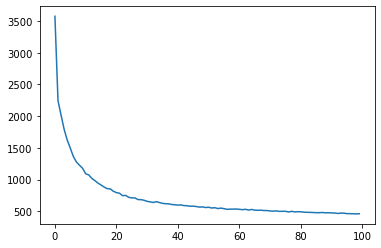

In [92]:
plt.plot(loss_timeseries)

In [90]:
import numpy as np
from ipywidgets import interact
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

def predicted_vs_true(i=100):
    fig, ax = plt.subplots()
    predicted = np.concatenate([y[1].detach().numpy() for y in ys[i]])
    true = np.concatenate([y[2].detach().numpy() for y in ys[i]]).reshape(-1, 1)
    ax.scatter(predicted, true)
    ax.set(xlim=(0, 15), ylim=(0, 15))
    ax.set_xlabel("Predicted y")
    ax.set_ylabel("True y")
    x = np.linspace(0, 15, 10)
    ax.plot(x, x)
    ax.set_aspect('equal', adjustable='box')
    plt.show()

    print('R2: Goodness of fit measure: ', r2_score(true, predicted))
    print("All outputs are equal: ", all(elem==predicted[0] for elem in predicted))
    mse = mean_squared_error(true, predicted)
    print("MSE: %f" % (mse))
    print("RMSE: %f" % (np.sqrt(mse)))

interact(predicted_vs_true, i=(0, len(ys)-1));

interactive(children=(IntSlider(value=99, description='i', max=99), Output()), _dom_classes=('widget-interact'…

Let's see how the model predicts the whole dataset!

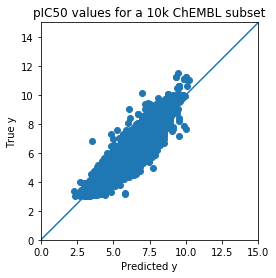

R2: Goodness of fit measure:  0.8942098979156023
All outputs are equal:  False
MSE: 0.193806
RMSE: 0.440234


In [93]:
model_input = torch.tensor(datasets[0].systems).type(torch.FloatTensor)
true = datasets[0].measurements

delta_g = model(model_input)
prediction = datasets[0].observation_model(delta_g).detach().numpy()


fig, ax = plt.subplots()
ax.scatter(prediction, true)
ax.set(xlim=(0, 15), ylim=(0, 15))
ax.set_xlabel("Predicted y")
ax.set_ylabel("True y")
ax.set_title("pIC50 values for a 10k ChEMBL subset")
x = np.linspace(0, 15, 10)
ax.plot(x, x)
ax.set_aspect('equal', adjustable='box')
plt.show()

print('R2: Goodness of fit measure: ', r2_score(true, prediction))
print("All outputs are equal: ", all(elem==prediction[0] for elem in prediction))
mse = mean_squared_error(true, prediction)
print("MSE: %f" % (mse))
print("RMSE: %f" % (np.sqrt(mse)))